# Importing Libraries in Python


- ## `satgenerator`: Generate Random Test Satellites
The `satgenerator` has class   `SatelliteCoordinateGenerator()` class that creates instances for generating random test satellites with the following parameters:
- `R`: Radial distance range
- `h`: Height range
- `phi`: Azimuthal angle
- `Ngal`: Number of test satellites



- ## `integration`: Performs forward and backward integrations
This has two classes `ForwardIntegration` and `BackwardIntegration` for forward and backward integrations






In [1]:
from satelliteplane.satgenerator import SatelliteCoordinateGenerator as GenSat
from satelliteplane.integration import ForwardIntegration, BackwardIntegration
import numpy as np
from galpy.potential import MWPotential2014
from astropy import units
import matplotlib.pyplot as plt


In [2]:
def MWPotential(scale=1):
    """
    Calculate the Milky Way potential.

    Parameters:
    - scale (float): Scaling factor for the Milky Way potential. Defaults to 1.

    Returns:
    - list: A modified Milky Way potential based on the input scale factor.
    """

    # Input validation
    if not isinstance(scale, (int, float)):
        raise TypeError("Scale must be a numerical value.")

    # Copy the Milky Way potential
    MW = MWPotential2014.copy()

    # Scale the potential
    MW[2] *= scale
    
    if scale < 1.:
        print(f"Halo mass decreased by {100 * (1 - scale):.2f}%.")
    elif scale > 1.:
        print(f"Halo mass increases by {100 * (scale - 1):.2f}%.")
    else:
        print(f"Halo mass remains the same.")
        
    return MW

## Initial Conditions:

In [16]:
R = [20, 250] #kpc Radial distribution range
h  = [0, 20] #kpc Vertical distribution range
phi = [0, 2*np.pi] 
Ngal = 25 #Number of test satellites

# ==========================================
#       Time
# ==========================================
Nstep = 3001 # Time step
t_max = 5 #Gyr Max time of integration
tf= np.linspace(0.,t_max,Nstep)*units.Gyr
tb= np.linspace(0.,-t_max,Nstep)*units.Gyr

# ==========================================
#       Potentials
# ==========================================
POT_forward = MWPotential2014
pot_vel = MWPotential2014
POT_backward = MWPotential2014

theta_tan = 80 #degree Angle to rotate the tangeltial unit vector of velocity

N_realization = 20
M_realization = 30
sat = GenSat(R, h, phi, Ngal)

Calling `sat.generate_random_values()` method to generate random `R`, `h` and `phi`

In [17]:
sat.generate_random_values()

Calling `sat.get_cartesian_coordinates()` to convert the intial cyl to Cartesian coordinates
- `theta`: (optional parameter): to rotate the plane about y-axis

In [18]:
pos =sat.get_cartesian_coordinates(theta=np.pi/2)

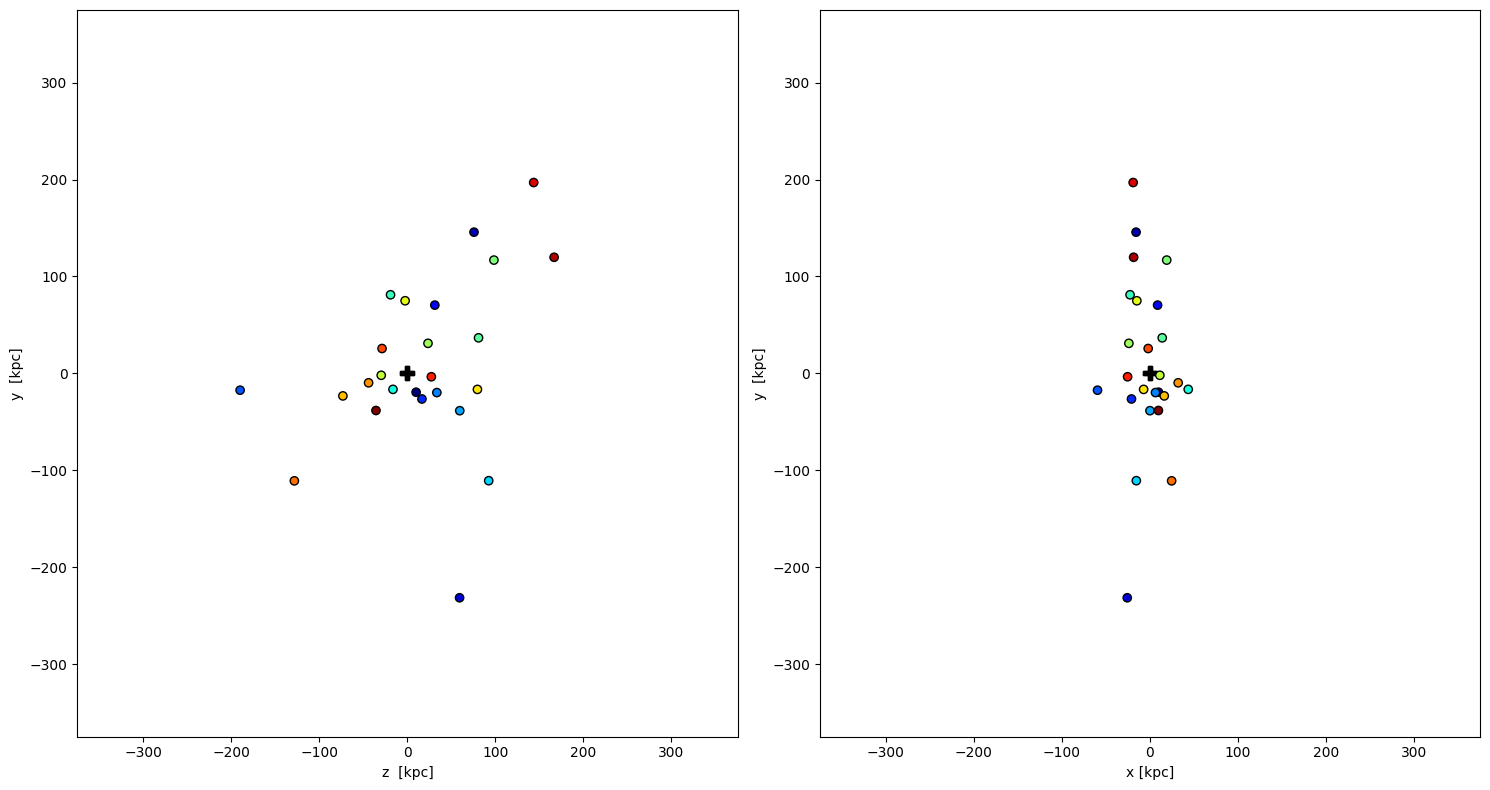

In [19]:
sat.plot()

## `ForwardIntegration()` instance to perform forward integration

Parameters
- `cart_pos`: Postion of satellites in cart coordinates
-  `theta_tan`: Angle for tangential velocity component
- `tf`: Time array
- `POT_forward`: Potential for forward integrations
- `N_realization` (optional): Number of forward realization, default =1  

In [20]:
forward_orbital_int = ForwardIntegration(pos, theta_tan, tf, POT_forward, N_realization= N_realization)

# `.get_ca_for()` method to get the `c/a` for forward integration

In [21]:
forward_orbital_int.get_ca_for(do_print = False)

In [44]:
ca_for_all = forward_orbital_int.ca_for_all
ca_for_mean = forward_orbital_int.ca_for_mean
ca_for_std = forward_orbital_int.ca_for_std

In [23]:
forward_orbital_int.get_unbound_sat(max_r=300)

In [24]:
unbound_sat_for_all = forward_orbital_int.unbound_sat_for_all
unbound_sat_for_mean = forward_orbital_int.unbound_sat_for_mean
unbound_sat_for_std = forward_orbital_int.unbound_sat_for_std

# `BackwardIntegration()` instance to perform backward integration


Parameters
- `forward_int`: Output of Forward instance
- `tb`: Time array for backward integration
- `pot_back`: Potential for backward integrations
- `M_realization` (optional): Number of forward realization, default =1
- `pmerr_list [ra, dec]` (optional): Errors in proper motions, default = 0.00 mas/yr
- `errtype` (optional): Type of error distribution, defaltul = `normal`
- `dist_err`: (optional): Percentange errors in distance, default = 0%

In [25]:
backward_orbital_int  = BackwardIntegration(forward_orbital_int, tb, POT_backward, M_realization=2, pmerr_list = [0.04, 0.04])

# `.get_ca_back()` method to get the `c/a`

In [26]:
backward_orbital_int.get_ca_back()

In [27]:
ca_back_all = backward_orbital_int.ca_back_all
ca_back_mean = backward_orbital_int.ca_back_mean
ca_back_std = backward_orbital_int.ca_back_std

In [31]:
ca_back_all.shape

(20, 2, 3001)

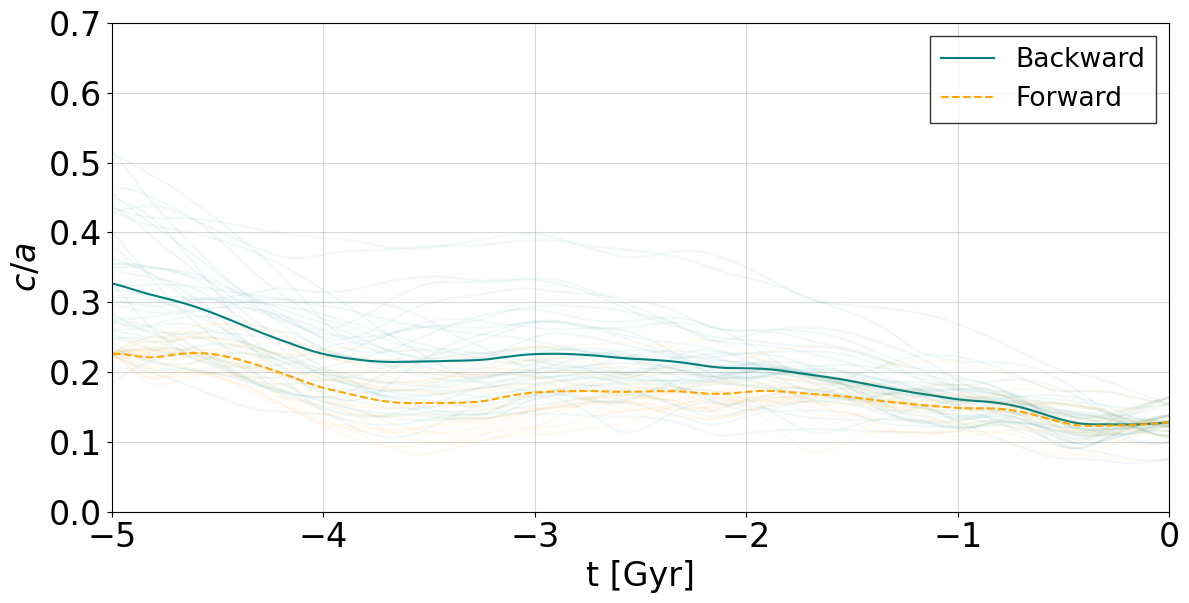

In [49]:
fig_size = 6
fig, ax =  plt.subplots(figsize =(fig_size*2,fig_size) )
ax.plot(tb, ca_back_mean,  color = "teal", label = "Backward")

for i in range(N_realization):
    ax.plot(tb, ca_back_all[i].T, color = "teal", alpha = 0.05)

ax.plot(tb, np.flip(ca_for_mean), "--", color = "orange", label = "Forward")
ax.plot(tb, np.flip(ca_for_all.T), color = "orange",  alpha = 0.05)
ax.set_xlabel("t [Gyr]", fontsize=4*fig_size)
ax.set_ylabel("$c/a$", fontsize=4*fig_size)
ax.set_xlim([-5,0])
ax.set_ylim([0,0.7])
ax.legend(fontsize = 3.2*fig_size, loc="upper right", edgecolor="black", fancybox=False)
ax.tick_params(axis='both', which='major', labelsize=4*fig_size)
ax.grid(alpha=0.5)
fig.tight_layout()
#fig.savefig("with_diff_h.pdf", format = "pdf", bbox_inches = "tight", dpi = 300)
